In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
%matplotlib inline

In [2]:
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
import keras
from keras import backend as K
import tensorflow as tf

D:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from rl.agents import *
from rl.policy import *
from rl.memory import *
from rl.random import *
import gym
from gym import Env, Space, spaces

In [21]:
class TestEnv(Env):
    metadata = {'render.modes': ['human', 'rgb_array']}

    def __init__(self, num, step_size) -> None:
        self.num = num
        self.step_size = step_size
        
        self.data = np.cumsum(np.random.choice([-1, 0, 1], self.num))
        self.data = (self.data - self.data.min())/(self.data.max() - self.data.min())
        
        self.step_begin = 0
        self.step_end = self.step_begin + self.step_size
        
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(0, 1, (step_size, ), float)

    def step(self, action):
        price_del = self.data[self.step_end] - self.data[self.step_end-1]
        if action == 1:
            reward = price_del
        elif action == 0:
            reward = -price_del
        else:
            raise Exception()
        
        self.step_begin += 1
        self.step_end += 1
        
        state = self.data[self.step_begin:self.step_end]
        
        if self.step_end < self.data.size-1:
            finished = False
        else:
            finished = True
        
        return state, reward, finished, {}

    def reset(self):
        self.step_begin = 0
        self.step_end = self.step_begin + self.step_size
        return self.data[self.step_begin:self.step_end]

    def seed(self, seed=None):
        pass

    def render(self, mode='human', close=False):
        if not close:
            plt.plot(self.data)

    def close(self):
        pass

In [41]:
env = TestEnv(100, 10)

In [56]:
np.save('./weights/keras_rl_random_walk.npy', env.data)

In [23]:
env.data = np.load('./weights/keras_rl_random_walk.npy')

In [24]:
env.reset()

array([0.71428571, 0.85714286, 1.        , 0.85714286, 0.85714286,
       0.85714286, 1.        , 1.        , 1.        , 0.85714286])

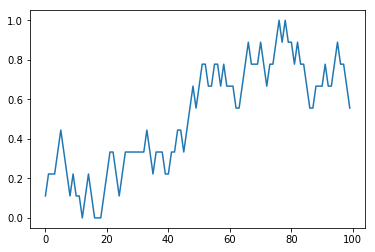

In [42]:
env.render()

In [27]:
window_length = 1
x = Input((window_length, ) + env.observation_space.shape)
y = Flatten()(x)
y = Dense(16, activation='elu')(y)
y = Dense(16, activation='elu')(y)
y = Dense(env.action_space.n)(y)
model = Model(x, y)

In [28]:
memory = SequentialMemory(limit=100000, window_length=window_length)
policy = EpsGreedyQPolicy()
dqn = DQNAgent(model=model, nb_actions=env.action_space.n, memory=memory, nb_steps_warmup=1000, gamma=.95, batch_size=32,
               enable_dueling_network=True, dueling_type='avg', target_model_update=.1, policy=policy)

In [29]:
dqn.compile(Adam(), metrics=['mae'])

In [30]:
hist = dqn.fit(env, nb_steps=100000, visualize=False, verbose=2, callbacks=None)

Training for 100000 steps ...
    89/100000: episode: 1, duration: 0.348s, episode steps: 89, steps per second: 256, episode reward: -0.143, mean reward: -0.002 [-0.143, 0.143], mean action: 0.888 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: --, mean_absolute_error: --, mean_q: --
   178/100000: episode: 2, duration: 0.121s, episode steps: 89, steps per second: 734, episode reward: 0.143, mean reward: 0.002 [-0.143, 0.143], mean action: 0.843 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: --, mean_absolute_error: --, mean_q: --
   267/100000: episode: 3, duration: 0.126s, episode steps: 89, steps per second: 704, episode reward: 0.429, mean reward: 0.005 [-0.143, 0.143], mean action: 0.798 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: --, mean_absolute_error: --, mean_q: --
   356/100000: episode: 4, duration: 0.111s, episode steps: 89, steps per second: 801, episode reward: -0.429, mean reward: -0.005 [-0.143, 0.143], mean action: 0.831 

  2759/100000: episode: 31, duration: 1.126s, episode steps: 89, steps per second: 79, episode reward: 2.714, mean reward: 0.030 [-0.143, 0.143], mean action: 0.517 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.006471, mean_absolute_error: 0.254659, mean_q: 0.477101
  2848/100000: episode: 32, duration: 0.938s, episode steps: 89, steps per second: 95, episode reward: 3.286, mean reward: 0.037 [-0.143, 0.143], mean action: 0.539 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.007058, mean_absolute_error: 0.262151, mean_q: 0.490606
  2937/100000: episode: 33, duration: 1.135s, episode steps: 89, steps per second: 78, episode reward: 3.000, mean reward: 0.034 [-0.143, 0.143], mean action: 0.506 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.006836, mean_absolute_error: 0.255574, mean_q: 0.481835
  3026/100000: episode: 34, duration: 1.201s, episode steps: 89, steps per second: 74, episode reward: 2.714, mean reward: 0.030 [-0.143, 0.143],

  5340/100000: episode: 60, duration: 1.048s, episode steps: 89, steps per second: 85, episode reward: 1.857, mean reward: 0.021 [-0.143, 0.143], mean action: 0.539 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.005945, mean_absolute_error: 0.282080, mean_q: 0.541531
  5429/100000: episode: 61, duration: 0.928s, episode steps: 89, steps per second: 96, episode reward: 3.286, mean reward: 0.037 [-0.143, 0.143], mean action: 0.427 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.006209, mean_absolute_error: 0.280792, mean_q: 0.543002
  5518/100000: episode: 62, duration: 0.889s, episode steps: 89, steps per second: 100, episode reward: 3.000, mean reward: 0.034 [-0.143, 0.143], mean action: 0.483 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.006047, mean_absolute_error: 0.282548, mean_q: 0.548681
  5607/100000: episode: 63, duration: 0.860s, episode steps: 89, steps per second: 103, episode reward: 1.571, mean reward: 0.018 [-0.143, 0.143

  7921/100000: episode: 89, duration: 1.003s, episode steps: 89, steps per second: 89, episode reward: 2.714, mean reward: 0.030 [-0.143, 0.143], mean action: 0.461 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.004992, mean_absolute_error: 0.301738, mean_q: 0.606918
  8010/100000: episode: 90, duration: 0.965s, episode steps: 89, steps per second: 92, episode reward: 4.143, mean reward: 0.047 [-0.143, 0.143], mean action: 0.494 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.005527, mean_absolute_error: 0.299463, mean_q: 0.601003
  8099/100000: episode: 91, duration: 0.899s, episode steps: 89, steps per second: 99, episode reward: 3.571, mean reward: 0.040 [-0.143, 0.143], mean action: 0.461 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.005616, mean_absolute_error: 0.298160, mean_q: 0.592778
  8188/100000: episode: 92, duration: 0.884s, episode steps: 89, steps per second: 101, episode reward: 3.857, mean reward: 0.043 [-0.143, 0.143]

 10502/100000: episode: 118, duration: 0.951s, episode steps: 89, steps per second: 94, episode reward: 3.286, mean reward: 0.037 [-0.143, 0.143], mean action: 0.528 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.005631, mean_absolute_error: 0.321472, mean_q: 0.636128
 10591/100000: episode: 119, duration: 0.952s, episode steps: 89, steps per second: 93, episode reward: 3.286, mean reward: 0.037 [-0.143, 0.143], mean action: 0.461 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.005496, mean_absolute_error: 0.318627, mean_q: 0.630111
 10680/100000: episode: 120, duration: 1.026s, episode steps: 89, steps per second: 87, episode reward: 3.857, mean reward: 0.043 [-0.143, 0.143], mean action: 0.461 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.005455, mean_absolute_error: 0.317163, mean_q: 0.620612
 10769/100000: episode: 121, duration: 0.901s, episode steps: 89, steps per second: 99, episode reward: 3.571, mean reward: 0.040 [-0.143, 0.1

 13083/100000: episode: 147, duration: 0.880s, episode steps: 89, steps per second: 101, episode reward: 3.286, mean reward: 0.037 [-0.143, 0.143], mean action: 0.483 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.005170, mean_absolute_error: 0.306830, mean_q: 0.603770
 13172/100000: episode: 148, duration: 0.901s, episode steps: 89, steps per second: 99, episode reward: 3.286, mean reward: 0.037 [-0.143, 0.143], mean action: 0.517 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.004947, mean_absolute_error: 0.315673, mean_q: 0.628729
 13261/100000: episode: 149, duration: 0.898s, episode steps: 89, steps per second: 99, episode reward: 2.714, mean reward: 0.030 [-0.143, 0.143], mean action: 0.528 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.005144, mean_absolute_error: 0.307690, mean_q: 0.608086
 13350/100000: episode: 150, duration: 0.904s, episode steps: 89, steps per second: 98, episode reward: 3.286, mean reward: 0.037 [-0.143, 0.

 15664/100000: episode: 176, duration: 0.893s, episode steps: 89, steps per second: 100, episode reward: 3.571, mean reward: 0.040 [-0.143, 0.143], mean action: 0.483 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.004408, mean_absolute_error: 0.331223, mean_q: 0.681965
 15753/100000: episode: 177, duration: 1.012s, episode steps: 89, steps per second: 88, episode reward: 2.714, mean reward: 0.030 [-0.143, 0.143], mean action: 0.461 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.004280, mean_absolute_error: 0.331962, mean_q: 0.686789
 15842/100000: episode: 178, duration: 0.897s, episode steps: 89, steps per second: 99, episode reward: 3.571, mean reward: 0.040 [-0.143, 0.143], mean action: 0.517 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.004234, mean_absolute_error: 0.332238, mean_q: 0.687565
 15931/100000: episode: 179, duration: 1.278s, episode steps: 89, steps per second: 70, episode reward: 4.143, mean reward: 0.047 [-0.143, 0.

 18245/100000: episode: 205, duration: 0.887s, episode steps: 89, steps per second: 100, episode reward: 4.143, mean reward: 0.047 [-0.143, 0.143], mean action: 0.449 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003682, mean_absolute_error: 0.334531, mean_q: 0.712134
 18334/100000: episode: 206, duration: 0.909s, episode steps: 89, steps per second: 98, episode reward: 4.429, mean reward: 0.050 [-0.143, 0.143], mean action: 0.393 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.004095, mean_absolute_error: 0.330329, mean_q: 0.702727
 18423/100000: episode: 207, duration: 0.992s, episode steps: 89, steps per second: 90, episode reward: 4.714, mean reward: 0.053 [-0.143, 0.143], mean action: 0.449 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.004128, mean_absolute_error: 0.333262, mean_q: 0.705967
 18512/100000: episode: 208, duration: 0.910s, episode steps: 89, steps per second: 98, episode reward: 3.571, mean reward: 0.040 [-0.143, 0.

 20826/100000: episode: 234, duration: 0.923s, episode steps: 89, steps per second: 96, episode reward: 4.714, mean reward: 0.053 [-0.143, 0.143], mean action: 0.483 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003170, mean_absolute_error: 0.374202, mean_q: 0.792217
 20915/100000: episode: 235, duration: 0.900s, episode steps: 89, steps per second: 99, episode reward: 4.429, mean reward: 0.050 [-0.143, 0.143], mean action: 0.461 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003131, mean_absolute_error: 0.376922, mean_q: 0.800271
 21004/100000: episode: 236, duration: 0.952s, episode steps: 89, steps per second: 93, episode reward: 4.429, mean reward: 0.050 [-0.143, 0.143], mean action: 0.551 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003299, mean_absolute_error: 0.379295, mean_q: 0.804663
 21093/100000: episode: 237, duration: 0.983s, episode steps: 89, steps per second: 91, episode reward: 4.429, mean reward: 0.050 [-0.143, 0.1

 23407/100000: episode: 263, duration: 0.956s, episode steps: 89, steps per second: 93, episode reward: 5.286, mean reward: 0.059 [-0.143, 0.143], mean action: 0.427 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003535, mean_absolute_error: 0.421986, mean_q: 0.892962
 23496/100000: episode: 264, duration: 0.898s, episode steps: 89, steps per second: 99, episode reward: 3.857, mean reward: 0.043 [-0.143, 0.143], mean action: 0.528 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003324, mean_absolute_error: 0.412040, mean_q: 0.874422
 23585/100000: episode: 265, duration: 0.917s, episode steps: 89, steps per second: 97, episode reward: 3.286, mean reward: 0.037 [-0.143, 0.143], mean action: 0.528 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003226, mean_absolute_error: 0.426273, mean_q: 0.903727
 23674/100000: episode: 266, duration: 0.910s, episode steps: 89, steps per second: 98, episode reward: 4.714, mean reward: 0.053 [-0.143, 0.1

 25988/100000: episode: 292, duration: 0.988s, episode steps: 89, steps per second: 90, episode reward: 5.000, mean reward: 0.056 [-0.143, 0.143], mean action: 0.539 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003697, mean_absolute_error: 0.447759, mean_q: 0.943541
 26077/100000: episode: 293, duration: 0.900s, episode steps: 89, steps per second: 99, episode reward: 5.286, mean reward: 0.059 [-0.143, 0.143], mean action: 0.528 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003565, mean_absolute_error: 0.448440, mean_q: 0.941873
 26166/100000: episode: 294, duration: 1.146s, episode steps: 89, steps per second: 78, episode reward: 4.143, mean reward: 0.047 [-0.143, 0.143], mean action: 0.517 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003749, mean_absolute_error: 0.444459, mean_q: 0.942829
 26255/100000: episode: 295, duration: 1.067s, episode steps: 89, steps per second: 83, episode reward: 3.571, mean reward: 0.040 [-0.143, 0.1

 28569/100000: episode: 321, duration: 0.903s, episode steps: 89, steps per second: 99, episode reward: 5.000, mean reward: 0.056 [-0.143, 0.143], mean action: 0.472 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003889, mean_absolute_error: 0.466196, mean_q: 0.990159
 28658/100000: episode: 322, duration: 0.933s, episode steps: 89, steps per second: 95, episode reward: 5.857, mean reward: 0.066 [-0.143, 0.143], mean action: 0.528 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003739, mean_absolute_error: 0.478791, mean_q: 1.012237
 28747/100000: episode: 323, duration: 0.908s, episode steps: 89, steps per second: 98, episode reward: 5.000, mean reward: 0.056 [-0.143, 0.143], mean action: 0.483 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003736, mean_absolute_error: 0.481915, mean_q: 1.022945
 28836/100000: episode: 324, duration: 0.902s, episode steps: 89, steps per second: 99, episode reward: 4.714, mean reward: 0.053 [-0.143, 0.1

 31150/100000: episode: 350, duration: 0.999s, episode steps: 89, steps per second: 89, episode reward: 5.286, mean reward: 0.059 [-0.143, 0.143], mean action: 0.438 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003844, mean_absolute_error: 0.526295, mean_q: 1.107486
 31239/100000: episode: 351, duration: 0.985s, episode steps: 89, steps per second: 90, episode reward: 6.143, mean reward: 0.069 [-0.143, 0.143], mean action: 0.528 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.004269, mean_absolute_error: 0.522560, mean_q: 1.101689
 31328/100000: episode: 352, duration: 0.930s, episode steps: 89, steps per second: 96, episode reward: 5.286, mean reward: 0.059 [-0.143, 0.143], mean action: 0.483 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003980, mean_absolute_error: 0.530114, mean_q: 1.118204
 31417/100000: episode: 353, duration: 0.933s, episode steps: 89, steps per second: 95, episode reward: 5.571, mean reward: 0.063 [-0.143, 0.1

 33731/100000: episode: 379, duration: 0.909s, episode steps: 89, steps per second: 98, episode reward: 6.143, mean reward: 0.069 [-0.143, 0.143], mean action: 0.472 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.004663, mean_absolute_error: 0.586463, mean_q: 1.223447
 33820/100000: episode: 380, duration: 0.898s, episode steps: 89, steps per second: 99, episode reward: 4.714, mean reward: 0.053 [-0.143, 0.143], mean action: 0.506 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.004846, mean_absolute_error: 0.586542, mean_q: 1.228329
 33909/100000: episode: 381, duration: 0.918s, episode steps: 89, steps per second: 97, episode reward: 5.857, mean reward: 0.066 [-0.143, 0.143], mean action: 0.528 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.004635, mean_absolute_error: 0.571799, mean_q: 1.192355
 33998/100000: episode: 382, duration: 0.898s, episode steps: 89, steps per second: 99, episode reward: 5.571, mean reward: 0.063 [-0.143, 0.1

 36312/100000: episode: 408, duration: 0.892s, episode steps: 89, steps per second: 100, episode reward: 5.857, mean reward: 0.066 [-0.143, 0.143], mean action: 0.461 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.004311, mean_absolute_error: 0.612655, mean_q: 1.280443
 36401/100000: episode: 409, duration: 0.942s, episode steps: 89, steps per second: 94, episode reward: 5.857, mean reward: 0.066 [-0.143, 0.143], mean action: 0.449 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.004059, mean_absolute_error: 0.616657, mean_q: 1.294347
 36490/100000: episode: 410, duration: 0.982s, episode steps: 89, steps per second: 91, episode reward: 6.143, mean reward: 0.069 [-0.143, 0.143], mean action: 0.483 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.004611, mean_absolute_error: 0.609280, mean_q: 1.270066
 36579/100000: episode: 411, duration: 0.945s, episode steps: 89, steps per second: 94, episode reward: 5.571, mean reward: 0.063 [-0.143, 0.

 38893/100000: episode: 437, duration: 0.927s, episode steps: 89, steps per second: 96, episode reward: 5.857, mean reward: 0.066 [-0.143, 0.143], mean action: 0.483 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003937, mean_absolute_error: 0.574711, mean_q: 1.216318
 38982/100000: episode: 438, duration: 0.899s, episode steps: 89, steps per second: 99, episode reward: 5.286, mean reward: 0.059 [-0.143, 0.143], mean action: 0.506 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.004109, mean_absolute_error: 0.581737, mean_q: 1.217376
 39071/100000: episode: 439, duration: 0.904s, episode steps: 89, steps per second: 98, episode reward: 6.143, mean reward: 0.069 [-0.143, 0.143], mean action: 0.416 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.004291, mean_absolute_error: 0.585649, mean_q: 1.222193
 39160/100000: episode: 440, duration: 0.920s, episode steps: 89, steps per second: 97, episode reward: 6.143, mean reward: 0.069 [-0.143, 0.1

 41474/100000: episode: 466, duration: 0.915s, episode steps: 89, steps per second: 97, episode reward: 5.857, mean reward: 0.066 [-0.143, 0.143], mean action: 0.438 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003493, mean_absolute_error: 0.540219, mean_q: 1.145874
 41563/100000: episode: 467, duration: 1.002s, episode steps: 89, steps per second: 89, episode reward: 5.571, mean reward: 0.063 [-0.143, 0.143], mean action: 0.528 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003784, mean_absolute_error: 0.553612, mean_q: 1.167924
 41652/100000: episode: 468, duration: 0.941s, episode steps: 89, steps per second: 95, episode reward: 5.286, mean reward: 0.059 [-0.143, 0.143], mean action: 0.517 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003634, mean_absolute_error: 0.555405, mean_q: 1.169742
 41741/100000: episode: 469, duration: 0.890s, episode steps: 89, steps per second: 100, episode reward: 5.857, mean reward: 0.066 [-0.143, 0.

 44055/100000: episode: 495, duration: 0.938s, episode steps: 89, steps per second: 95, episode reward: 5.857, mean reward: 0.066 [-0.143, 0.143], mean action: 0.562 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003534, mean_absolute_error: 0.539679, mean_q: 1.140831
 44144/100000: episode: 496, duration: 0.934s, episode steps: 89, steps per second: 95, episode reward: 5.571, mean reward: 0.063 [-0.143, 0.143], mean action: 0.483 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003548, mean_absolute_error: 0.551953, mean_q: 1.158001
 44233/100000: episode: 497, duration: 0.954s, episode steps: 89, steps per second: 93, episode reward: 5.857, mean reward: 0.066 [-0.143, 0.143], mean action: 0.517 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003367, mean_absolute_error: 0.532531, mean_q: 1.126585
 44322/100000: episode: 498, duration: 0.956s, episode steps: 89, steps per second: 93, episode reward: 5.571, mean reward: 0.063 [-0.143, 0.1

 46636/100000: episode: 524, duration: 0.977s, episode steps: 89, steps per second: 91, episode reward: 7.000, mean reward: 0.079 [-0.143, 0.143], mean action: 0.461 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003199, mean_absolute_error: 0.508932, mean_q: 1.083469
 46725/100000: episode: 525, duration: 0.914s, episode steps: 89, steps per second: 97, episode reward: 7.000, mean reward: 0.079 [-0.143, 0.143], mean action: 0.438 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.002984, mean_absolute_error: 0.497269, mean_q: 1.062555
 46814/100000: episode: 526, duration: 0.961s, episode steps: 89, steps per second: 93, episode reward: 7.000, mean reward: 0.079 [-0.143, 0.143], mean action: 0.506 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003306, mean_absolute_error: 0.506527, mean_q: 1.073090
 46903/100000: episode: 527, duration: 0.946s, episode steps: 89, steps per second: 94, episode reward: 6.143, mean reward: 0.069 [-0.143, 0.1

 49217/100000: episode: 553, duration: 0.979s, episode steps: 89, steps per second: 91, episode reward: 5.571, mean reward: 0.063 [-0.143, 0.143], mean action: 0.449 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.002732, mean_absolute_error: 0.493159, mean_q: 1.056701
 49306/100000: episode: 554, duration: 1.067s, episode steps: 89, steps per second: 83, episode reward: 6.143, mean reward: 0.069 [-0.143, 0.143], mean action: 0.461 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.003070, mean_absolute_error: 0.496072, mean_q: 1.063661
 49395/100000: episode: 555, duration: 0.969s, episode steps: 89, steps per second: 92, episode reward: 6.714, mean reward: 0.075 [-0.143, 0.143], mean action: 0.461 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.002994, mean_absolute_error: 0.492721, mean_q: 1.050545
 49484/100000: episode: 556, duration: 1.085s, episode steps: 89, steps per second: 82, episode reward: 7.000, mean reward: 0.079 [-0.143, 0.1

 51798/100000: episode: 582, duration: 1.023s, episode steps: 89, steps per second: 87, episode reward: 6.714, mean reward: 0.075 [-0.143, 0.143], mean action: 0.438 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.002860, mean_absolute_error: 0.481553, mean_q: 1.041060
 51887/100000: episode: 583, duration: 1.193s, episode steps: 89, steps per second: 75, episode reward: 6.143, mean reward: 0.069 [-0.143, 0.143], mean action: 0.472 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.002737, mean_absolute_error: 0.501917, mean_q: 1.082572
 51976/100000: episode: 584, duration: 1.065s, episode steps: 89, steps per second: 84, episode reward: 6.143, mean reward: 0.069 [-0.143, 0.143], mean action: 0.517 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.002980, mean_absolute_error: 0.499095, mean_q: 1.065280
 52065/100000: episode: 585, duration: 0.940s, episode steps: 89, steps per second: 95, episode reward: 7.571, mean reward: 0.085 [0.000, 0.14

 54379/100000: episode: 611, duration: 0.933s, episode steps: 89, steps per second: 95, episode reward: 6.429, mean reward: 0.072 [-0.143, 0.143], mean action: 0.371 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.002480, mean_absolute_error: 0.486337, mean_q: 1.052848
 54468/100000: episode: 612, duration: 0.918s, episode steps: 89, steps per second: 97, episode reward: 6.429, mean reward: 0.072 [-0.143, 0.143], mean action: 0.382 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.002233, mean_absolute_error: 0.495515, mean_q: 1.069929
 54557/100000: episode: 613, duration: 1.047s, episode steps: 89, steps per second: 85, episode reward: 6.714, mean reward: 0.075 [-0.143, 0.143], mean action: 0.461 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.002388, mean_absolute_error: 0.480164, mean_q: 1.038104
 54646/100000: episode: 614, duration: 0.917s, episode steps: 89, steps per second: 97, episode reward: 5.571, mean reward: 0.063 [-0.143, 0.1

 56960/100000: episode: 640, duration: 0.902s, episode steps: 89, steps per second: 99, episode reward: 6.143, mean reward: 0.069 [-0.143, 0.143], mean action: 0.461 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.002196, mean_absolute_error: 0.479891, mean_q: 1.033914
 57049/100000: episode: 641, duration: 0.942s, episode steps: 89, steps per second: 94, episode reward: 6.714, mean reward: 0.075 [-0.143, 0.143], mean action: 0.404 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001923, mean_absolute_error: 0.476285, mean_q: 1.036726
 57138/100000: episode: 642, duration: 1.004s, episode steps: 89, steps per second: 89, episode reward: 6.714, mean reward: 0.075 [-0.143, 0.143], mean action: 0.382 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.002286, mean_absolute_error: 0.472859, mean_q: 1.024369
 57227/100000: episode: 643, duration: 0.976s, episode steps: 89, steps per second: 91, episode reward: 5.000, mean reward: 0.056 [-0.143, 0.1

 59541/100000: episode: 669, duration: 1.021s, episode steps: 89, steps per second: 87, episode reward: 5.571, mean reward: 0.063 [-0.143, 0.143], mean action: 0.494 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.002017, mean_absolute_error: 0.474390, mean_q: 1.024616
 59630/100000: episode: 670, duration: 0.928s, episode steps: 89, steps per second: 96, episode reward: 6.714, mean reward: 0.075 [-0.143, 0.143], mean action: 0.382 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.002087, mean_absolute_error: 0.465162, mean_q: 1.012110
 59719/100000: episode: 671, duration: 0.926s, episode steps: 89, steps per second: 96, episode reward: 5.571, mean reward: 0.063 [-0.143, 0.143], mean action: 0.371 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.002047, mean_absolute_error: 0.465749, mean_q: 1.009596
 59808/100000: episode: 672, duration: 0.905s, episode steps: 89, steps per second: 98, episode reward: 6.429, mean reward: 0.072 [-0.143, 0.1

 62122/100000: episode: 698, duration: 0.922s, episode steps: 89, steps per second: 97, episode reward: 6.429, mean reward: 0.072 [-0.143, 0.143], mean action: 0.449 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.002069, mean_absolute_error: 0.481101, mean_q: 1.043935
 62211/100000: episode: 699, duration: 0.918s, episode steps: 89, steps per second: 97, episode reward: 6.429, mean reward: 0.072 [-0.143, 0.143], mean action: 0.472 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001823, mean_absolute_error: 0.472337, mean_q: 1.030709
 62300/100000: episode: 700, duration: 0.900s, episode steps: 89, steps per second: 99, episode reward: 7.000, mean reward: 0.079 [-0.143, 0.143], mean action: 0.449 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001843, mean_absolute_error: 0.472326, mean_q: 1.029798
 62389/100000: episode: 701, duration: 0.919s, episode steps: 89, steps per second: 97, episode reward: 6.429, mean reward: 0.072 [-0.143, 0.1

 64703/100000: episode: 727, duration: 1.033s, episode steps: 89, steps per second: 86, episode reward: 5.571, mean reward: 0.063 [-0.143, 0.143], mean action: 0.472 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001779, mean_absolute_error: 0.481900, mean_q: 1.050180
 64792/100000: episode: 728, duration: 0.938s, episode steps: 89, steps per second: 95, episode reward: 7.000, mean reward: 0.079 [-0.143, 0.143], mean action: 0.382 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001748, mean_absolute_error: 0.485107, mean_q: 1.054462
 64881/100000: episode: 729, duration: 0.922s, episode steps: 89, steps per second: 96, episode reward: 6.714, mean reward: 0.075 [-0.143, 0.143], mean action: 0.404 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001748, mean_absolute_error: 0.482190, mean_q: 1.054706
 64970/100000: episode: 730, duration: 0.986s, episode steps: 89, steps per second: 90, episode reward: 6.429, mean reward: 0.072 [-0.143, 0.1

 67284/100000: episode: 756, duration: 1.071s, episode steps: 89, steps per second: 83, episode reward: 7.286, mean reward: 0.082 [-0.143, 0.143], mean action: 0.404 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001550, mean_absolute_error: 0.485531, mean_q: 1.058882
 67373/100000: episode: 757, duration: 1.080s, episode steps: 89, steps per second: 82, episode reward: 7.000, mean reward: 0.079 [-0.143, 0.143], mean action: 0.438 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001643, mean_absolute_error: 0.480692, mean_q: 1.050754
 67462/100000: episode: 758, duration: 0.905s, episode steps: 89, steps per second: 98, episode reward: 6.429, mean reward: 0.072 [-0.143, 0.143], mean action: 0.382 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001654, mean_absolute_error: 0.485521, mean_q: 1.060747
 67551/100000: episode: 759, duration: 0.921s, episode steps: 89, steps per second: 97, episode reward: 6.714, mean reward: 0.075 [-0.143, 0.1

 69865/100000: episode: 785, duration: 0.984s, episode steps: 89, steps per second: 90, episode reward: 7.286, mean reward: 0.082 [-0.143, 0.143], mean action: 0.416 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001613, mean_absolute_error: 0.501988, mean_q: 1.097051
 69954/100000: episode: 786, duration: 1.027s, episode steps: 89, steps per second: 87, episode reward: 6.143, mean reward: 0.069 [-0.143, 0.143], mean action: 0.438 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001414, mean_absolute_error: 0.488021, mean_q: 1.069600
 70043/100000: episode: 787, duration: 1.019s, episode steps: 89, steps per second: 87, episode reward: 6.429, mean reward: 0.072 [-0.143, 0.143], mean action: 0.449 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001395, mean_absolute_error: 0.485175, mean_q: 1.065081
 70132/100000: episode: 788, duration: 1.013s, episode steps: 89, steps per second: 88, episode reward: 7.000, mean reward: 0.079 [-0.143, 0.1

 72446/100000: episode: 814, duration: 0.944s, episode steps: 89, steps per second: 94, episode reward: 7.571, mean reward: 0.085 [0.000, 0.143], mean action: 0.427 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001345, mean_absolute_error: 0.520527, mean_q: 1.137459
 72535/100000: episode: 815, duration: 0.937s, episode steps: 89, steps per second: 95, episode reward: 7.000, mean reward: 0.079 [-0.143, 0.143], mean action: 0.371 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001331, mean_absolute_error: 0.527465, mean_q: 1.152374
 72624/100000: episode: 816, duration: 0.961s, episode steps: 89, steps per second: 93, episode reward: 6.429, mean reward: 0.072 [-0.143, 0.143], mean action: 0.416 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001426, mean_absolute_error: 0.526349, mean_q: 1.149611
 72713/100000: episode: 817, duration: 0.953s, episode steps: 89, steps per second: 93, episode reward: 7.286, mean reward: 0.082 [-0.143, 0.14

 75027/100000: episode: 843, duration: 1.152s, episode steps: 89, steps per second: 77, episode reward: 6.143, mean reward: 0.069 [-0.143, 0.143], mean action: 0.382 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001510, mean_absolute_error: 0.521081, mean_q: 1.139827
 75116/100000: episode: 844, duration: 0.925s, episode steps: 89, steps per second: 96, episode reward: 7.571, mean reward: 0.085 [0.000, 0.143], mean action: 0.449 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001411, mean_absolute_error: 0.509419, mean_q: 1.112168
 75205/100000: episode: 845, duration: 0.945s, episode steps: 89, steps per second: 94, episode reward: 6.429, mean reward: 0.072 [-0.143, 0.143], mean action: 0.472 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001311, mean_absolute_error: 0.505535, mean_q: 1.112146
 75294/100000: episode: 846, duration: 1.041s, episode steps: 89, steps per second: 85, episode reward: 6.714, mean reward: 0.075 [-0.143, 0.14

 77608/100000: episode: 872, duration: 0.963s, episode steps: 89, steps per second: 92, episode reward: 7.286, mean reward: 0.082 [-0.143, 0.143], mean action: 0.393 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001273, mean_absolute_error: 0.501922, mean_q: 1.103748
 77697/100000: episode: 873, duration: 0.931s, episode steps: 89, steps per second: 96, episode reward: 6.429, mean reward: 0.072 [-0.143, 0.143], mean action: 0.472 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001248, mean_absolute_error: 0.495848, mean_q: 1.088795
 77786/100000: episode: 874, duration: 0.938s, episode steps: 89, steps per second: 95, episode reward: 6.429, mean reward: 0.072 [-0.143, 0.143], mean action: 0.416 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001442, mean_absolute_error: 0.501960, mean_q: 1.099968
 77875/100000: episode: 875, duration: 0.966s, episode steps: 89, steps per second: 92, episode reward: 7.000, mean reward: 0.079 [-0.143, 0.1

 80189/100000: episode: 901, duration: 1.136s, episode steps: 89, steps per second: 78, episode reward: 6.714, mean reward: 0.075 [-0.143, 0.143], mean action: 0.416 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001327, mean_absolute_error: 0.518751, mean_q: 1.140704
 80278/100000: episode: 902, duration: 0.945s, episode steps: 89, steps per second: 94, episode reward: 6.429, mean reward: 0.072 [-0.143, 0.143], mean action: 0.449 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001190, mean_absolute_error: 0.528002, mean_q: 1.157325
 80367/100000: episode: 903, duration: 0.945s, episode steps: 89, steps per second: 94, episode reward: 7.286, mean reward: 0.082 [-0.143, 0.143], mean action: 0.449 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001237, mean_absolute_error: 0.515065, mean_q: 1.130991
 80456/100000: episode: 904, duration: 0.930s, episode steps: 89, steps per second: 96, episode reward: 7.286, mean reward: 0.082 [-0.143, 0.1

 82770/100000: episode: 930, duration: 1.110s, episode steps: 89, steps per second: 80, episode reward: 6.714, mean reward: 0.075 [-0.143, 0.143], mean action: 0.427 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001107, mean_absolute_error: 0.518195, mean_q: 1.141136
 82859/100000: episode: 931, duration: 0.952s, episode steps: 89, steps per second: 93, episode reward: 7.000, mean reward: 0.079 [-0.143, 0.143], mean action: 0.427 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001180, mean_absolute_error: 0.513194, mean_q: 1.132109
 82948/100000: episode: 932, duration: 0.947s, episode steps: 89, steps per second: 94, episode reward: 7.000, mean reward: 0.079 [-0.143, 0.143], mean action: 0.393 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001130, mean_absolute_error: 0.512250, mean_q: 1.130357
 83037/100000: episode: 933, duration: 0.971s, episode steps: 89, steps per second: 92, episode reward: 6.714, mean reward: 0.075 [-0.143, 0.1

 85351/100000: episode: 959, duration: 1.114s, episode steps: 89, steps per second: 80, episode reward: 7.286, mean reward: 0.082 [-0.143, 0.143], mean action: 0.427 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001133, mean_absolute_error: 0.540811, mean_q: 1.187284
 85440/100000: episode: 960, duration: 0.931s, episode steps: 89, steps per second: 96, episode reward: 6.714, mean reward: 0.075 [-0.143, 0.143], mean action: 0.449 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001197, mean_absolute_error: 0.532331, mean_q: 1.171783
 85529/100000: episode: 961, duration: 0.920s, episode steps: 89, steps per second: 97, episode reward: 7.286, mean reward: 0.082 [-0.143, 0.143], mean action: 0.472 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001108, mean_absolute_error: 0.534411, mean_q: 1.176927
 85618/100000: episode: 962, duration: 0.925s, episode steps: 89, steps per second: 96, episode reward: 5.857, mean reward: 0.066 [-0.143, 0.1

 87932/100000: episode: 988, duration: 0.930s, episode steps: 89, steps per second: 96, episode reward: 6.429, mean reward: 0.072 [-0.143, 0.143], mean action: 0.438 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001118, mean_absolute_error: 0.534107, mean_q: 1.173891
 88021/100000: episode: 989, duration: 0.916s, episode steps: 89, steps per second: 97, episode reward: 7.000, mean reward: 0.079 [-0.143, 0.143], mean action: 0.483 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001021, mean_absolute_error: 0.526553, mean_q: 1.160521
 88110/100000: episode: 990, duration: 0.931s, episode steps: 89, steps per second: 96, episode reward: 7.571, mean reward: 0.085 [0.000, 0.143], mean action: 0.438 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001175, mean_absolute_error: 0.524980, mean_q: 1.149394
 88199/100000: episode: 991, duration: 0.920s, episode steps: 89, steps per second: 97, episode reward: 6.429, mean reward: 0.072 [-0.143, 0.14

 90513/100000: episode: 1017, duration: 0.934s, episode steps: 89, steps per second: 95, episode reward: 7.000, mean reward: 0.079 [-0.143, 0.143], mean action: 0.472 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.000990, mean_absolute_error: 0.535131, mean_q: 1.181973
 90602/100000: episode: 1018, duration: 0.935s, episode steps: 89, steps per second: 95, episode reward: 6.429, mean reward: 0.072 [-0.143, 0.143], mean action: 0.483 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001109, mean_absolute_error: 0.518514, mean_q: 1.145136
 90691/100000: episode: 1019, duration: 0.920s, episode steps: 89, steps per second: 97, episode reward: 7.286, mean reward: 0.082 [-0.143, 0.143], mean action: 0.404 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001007, mean_absolute_error: 0.524659, mean_q: 1.161209
 90780/100000: episode: 1020, duration: 0.943s, episode steps: 89, steps per second: 94, episode reward: 6.143, mean reward: 0.069 [-0.143,

 93094/100000: episode: 1046, duration: 0.925s, episode steps: 89, steps per second: 96, episode reward: 7.286, mean reward: 0.082 [-0.143, 0.143], mean action: 0.416 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001029, mean_absolute_error: 0.542684, mean_q: 1.189095
 93183/100000: episode: 1047, duration: 0.936s, episode steps: 89, steps per second: 95, episode reward: 7.286, mean reward: 0.082 [-0.143, 0.143], mean action: 0.472 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.000939, mean_absolute_error: 0.532589, mean_q: 1.172278
 93272/100000: episode: 1048, duration: 0.937s, episode steps: 89, steps per second: 95, episode reward: 7.000, mean reward: 0.079 [-0.143, 0.143], mean action: 0.494 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001003, mean_absolute_error: 0.522503, mean_q: 1.155704
 93361/100000: episode: 1049, duration: 0.909s, episode steps: 89, steps per second: 98, episode reward: 6.143, mean reward: 0.069 [-0.143,

 95675/100000: episode: 1075, duration: 0.942s, episode steps: 89, steps per second: 95, episode reward: 7.286, mean reward: 0.082 [-0.143, 0.143], mean action: 0.449 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.000960, mean_absolute_error: 0.510884, mean_q: 1.131688
 95764/100000: episode: 1076, duration: 0.916s, episode steps: 89, steps per second: 97, episode reward: 6.714, mean reward: 0.075 [-0.143, 0.143], mean action: 0.360 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001032, mean_absolute_error: 0.518513, mean_q: 1.148485
 95853/100000: episode: 1077, duration: 0.930s, episode steps: 89, steps per second: 96, episode reward: 6.714, mean reward: 0.075 [-0.143, 0.143], mean action: 0.483 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001060, mean_absolute_error: 0.531772, mean_q: 1.172041
 95942/100000: episode: 1078, duration: 0.945s, episode steps: 89, steps per second: 94, episode reward: 6.714, mean reward: 0.075 [-0.143,

 98256/100000: episode: 1104, duration: 1.134s, episode steps: 89, steps per second: 78, episode reward: 7.000, mean reward: 0.079 [-0.143, 0.143], mean action: 0.427 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.000944, mean_absolute_error: 0.515493, mean_q: 1.146190
 98345/100000: episode: 1105, duration: 1.128s, episode steps: 89, steps per second: 79, episode reward: 7.571, mean reward: 0.085 [0.000, 0.143], mean action: 0.449 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.000957, mean_absolute_error: 0.520864, mean_q: 1.154970
 98434/100000: episode: 1106, duration: 1.121s, episode steps: 89, steps per second: 79, episode reward: 5.857, mean reward: 0.066 [-0.143, 0.143], mean action: 0.517 [0.000, 1.000], mean observation: 0.439 [0.000, 1.000], loss: 0.001069, mean_absolute_error: 0.511832, mean_q: 1.131700
 98523/100000: episode: 1107, duration: 1.142s, episode steps: 89, steps per second: 78, episode reward: 7.286, mean reward: 0.082 [-0.143, 

In [33]:
dqn.save_weights('./weights/keras_rl_random_walk.hdf5', True)

In [12]:
dqn.load_weights('./weights/keras_rl_random_walk.hdf5')

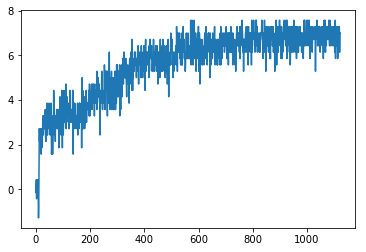

In [31]:
plt.plot(hist.history.get('episode_reward'))

Testing for 1 episodes ...
Episode 1: reward: 0.444, steps: 89


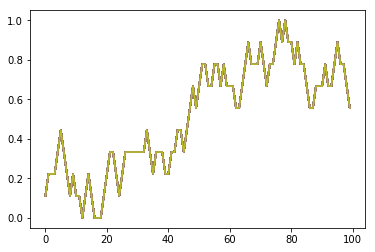

In [43]:
dqn.test(env)

In [35]:
datas = np.array([env.data[i:i+10] for i in range(0, env.data.size-10)])

In [46]:
pred = np.array([dqn.forward(env.data[i:i+10]) for i in range(0, env.data.size-10)])

In [36]:
pred = np.argmax(dqn.model.predict(datas[:, np.newaxis, :]), axis=1)

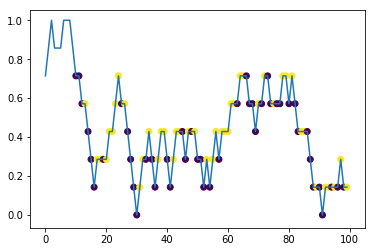

In [37]:
plt.plot(env.data)
plt.scatter(range(10, 100), env.data[10:100], c=pred)

In [38]:
rewards = [(env.data[i+10] - env.data[i+9])*(v-0.5)*2 for (i, v) in enumerate(pred)]

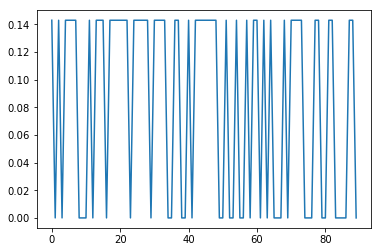

In [39]:
plt.plot(rewards)

In [40]:
np.sum(rewards)

7.57142857142857